In [1]:
import numpy as np 
import pandas as pd 
from metpy.interpolate import inverse_distance_to_grid
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import ffmpeg
import os

D:\anaconda\envs\anaconda_fffdesktop\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# 设置地理范围
x_min          = 35
x_max          = 45
y_min          = 15
y_max          = 26

months         = np.arange(1, 13, 1)

# 插值经纬度
grid_lon       = np.arange(x_min, x_max+1, 0.5)
grid_lat       = np.arange(y_min, y_max+1, 0.5)
x, y           = np.meshgrid(grid_lon, grid_lat)
# 站点经纬度
df_path        = r"C:\Users\Administrator\Desktop\000\Monthly climate Data - XZ (2).xlsx"
df             = pd.read_excel(df_path)
# 去缺省值
df             = df.dropna(axis=0)

In [3]:
# 读取站号
# 读取重复的站号, 即全部站号
duplicated_bool = df.duplicated(subset=['Station Number'], keep='first')
duplicated_station_id = df.loc[duplicated_bool == False]['Station Number']

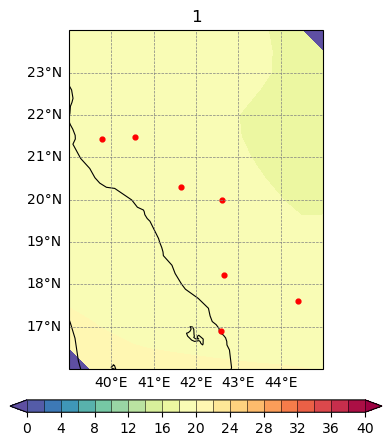

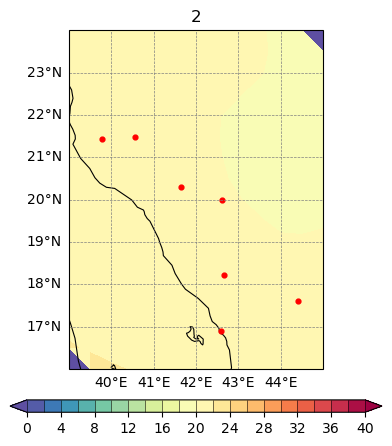

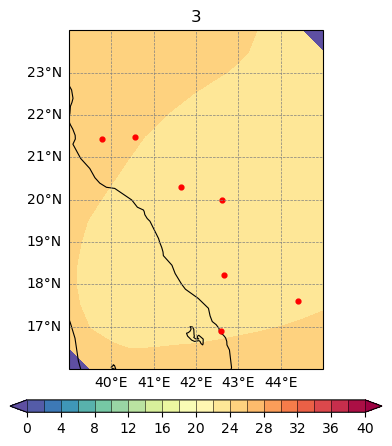

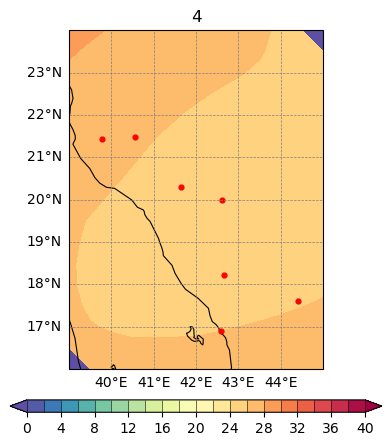

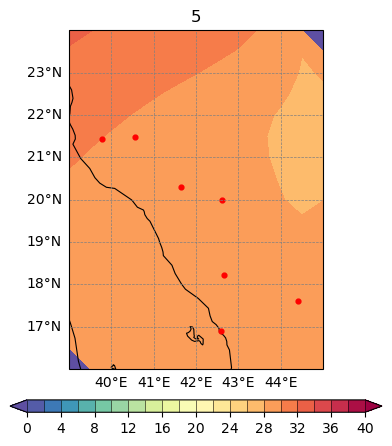

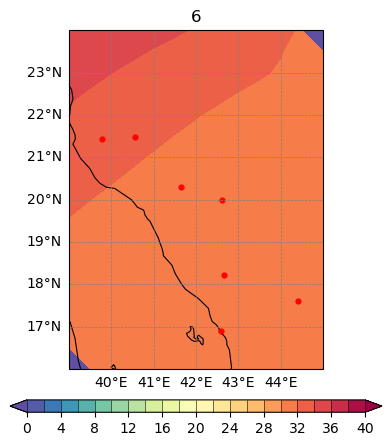

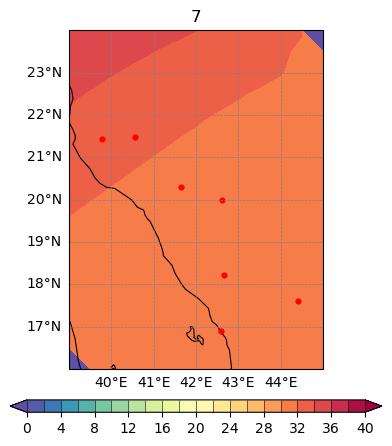

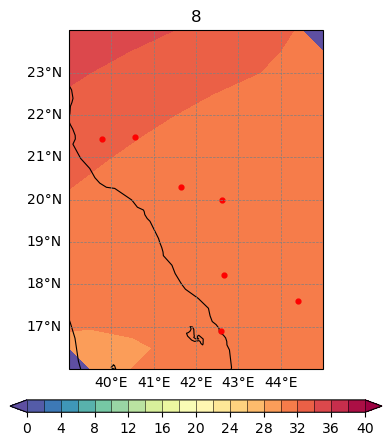

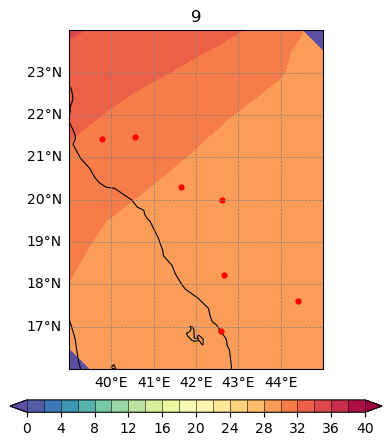

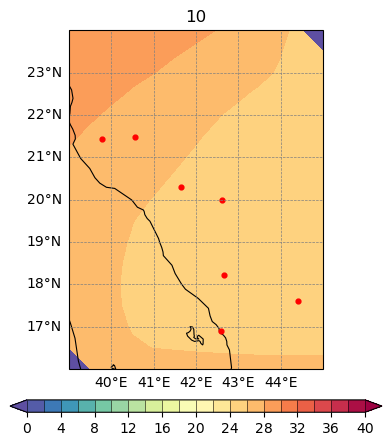

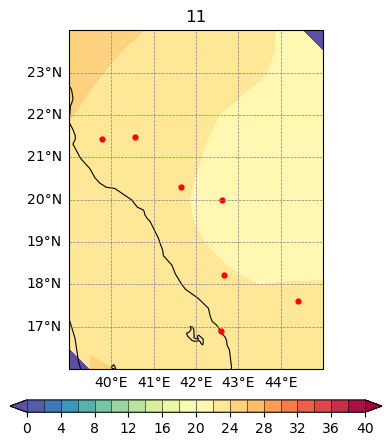

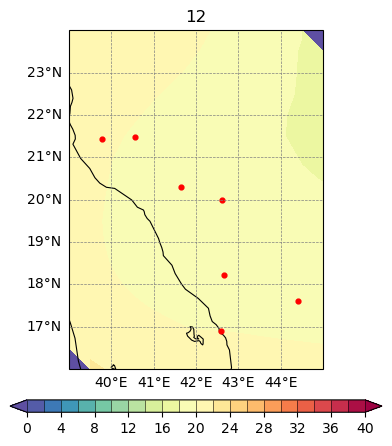

In [4]:
for mon in range(1, 13, 1):
    lat_all        = []
    lon_all        = []
    data_all       = []
    for station_num_test in duplicated_station_id:

        # 读取单站数据及经纬度信息
        df_station     = df[df['Station Number']==station_num_test]
        lat            = df_station['Lat'].values
        lon            = df_station['Long'].values
        data_test      = df_station[df_station['Month']==mon]['Air Temperature Mean Db']
        # 计算单站某个月的月平均
        data_test_mean = data_test.mean()

        # 保存单站的经纬度信息
        lat_all.append(lat[0])
        lon_all.append(lon[0])

        # 保存单站月平均数据
        data_all.append(data_test_mean)

    # 插值
    lon_all        = np.array(lon_all)
    lat_all        = np.array(lat_all)
    data_all       = np.array(data_all)
    data_grid      = inverse_distance_to_grid(xp=lon_all, yp=lat_all, variable=data_all, 
                                            grid_x=x, grid_y=y,
                                            r=5, kind='cressman')
    # 缺省值赋值-9999
    data_grid[np.isnan(data_grid)] = -9999
    # ----------------------------------------------------------
    # plot
    shp_path       = r"C:\Users\Administrator\Desktop\000\study area\study_area.shp"
    shp_reader     = Reader(shp_path)

    proj           = ccrs.PlateCarree()
    crs            = ccrs.PlateCarree()

    # 设置经纬度范围
    extent         = [39, 45, 16, 24]
    levels         = np.linspace(-0.5, 0.5, 11)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5), subplot_kw={'projection':crs}) 

    ax.set_extent(extent, proj)

    ax.spines['geo'].set_linewidth(0.8)
    ax.tick_params(axis='both',which='major',labelsize=9, direction='out',length=2.5,width=0.8,pad=1.5, bottom=True, left=True)
    ax.tick_params(axis='both',which='minor',direction='out',width=0.5,bottom=True,left=True)

    ax.add_geometries(shp_reader.geometries(), fc="None", ec="k", lw=0.8, crs=proj, zorder=2)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), fc='None', ec="k", lw=0.8, zorder=2)
    # 添加经纬度网格线
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    linewidth=0.5, linestyle='--', color='gray')

    gl.top_labels,gl.bottom_labels,gl.right_labels,gl.left_labels = False,True,False,True
    gl.rotate_labels = False
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(39, 46, 1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(15, 25, 1))
    gl.xlabel_style = {'size':10, 'color':'k'}
    gl.ylabel_style = {'size':10, 'color':'k'}

    cf = ax.contourf(x, y, data_grid,
                    levels=np.linspace(0, 40, 21),
                    extend='both',
                    cmap=plt.cm.Spectral_r, transform=proj)

    cbar     = plt.colorbar(cf, shrink=0.8,
                        orientation='horizontal', pad=0.08,
                        aspect=30, fraction=0.04,
                        drawedges=True, ticks=cf.levels[::2],
                        ax=ax)
    # cbar.set_label('mm')

    # 站点
    ax.scatter(lon_all, lat_all, c="r",s=12, transform=proj, zorder=2)
    # title 
    ax.set_title(str(mon))
    plt.show()
    plt.close()
    # 保存图片
    fig.savefig('./plot_temp_'+str(mon)+'.png', format='png', dpi=500, bbox_inches='tight')

    del lon_all, lat_all, data_grid, data_all

In [5]:
import os
import imageio.v2 as imageio

# 定义每个月份的图像文件路径
base_path = "C:\\Users\\Administrator\\Desktop\\000\\inverse interpolate picture"
month_files = ['{}.png'.format(i) for i in range(1, 13)]

# 构建完整的文件路径
month_paths = [os.path.join(base_path, month) for month in month_files]

# 读取每个月份的图像并存储到列表中
images = []
for path in month_paths:
    images.append(imageio.imread(path))

# 保存成gif动态图
imageio.mimsave('monthly_temperature.gif', images, fps=1, loop=5)
